# Hands-on with the U-Net

In this exercise you will take a look at a U-net architecture and will train your model with a tiny dataset. 

The objective of this exercise is not to train the best model ever, but rather to give you a feel for how the U-net model operates and how it can be applied to real-world datasets.

For this exercise the data consists is one abdominal CT scan with segmentation of the spleen. There is not quite enough to train a reasonable model, however you can play with parameters and overfit your model to this particular case so that it produces a segmentation that looks good. That is what we are going to do!

If you are feeling adventurous, and want to try and train this model for real, you can download the full spleen segmentation dataset from here: http://medicaldecathlon.com/

Below we provide some starter code and put comments prepended with TASK to indicate places where you need to fill in.

In [ ]:
#restart the kernel once after install this package
#!pip install nibabel

In [ ]:
# Imports for Medical Image Segmentation with PyTorch and Related Libraries
# 
# This block imports all the necessary libraries for building, training, and evaluating a U-Net model 
# for medical image segmentation.
# 
# - matplotlib.pyplot as plt: Used for plotting images and visualizations. Key functions: plt.imshow() for displaying images, 
# plt.title(), plt.axis(), plt.show().
# - matplotlib.cm as cm: Provides access to colormaps for image visualization.
# - numpy.ma as ma: Supports masked arrays, useful for handling invalid or missing data in arrays.
# - numpy as np: Fundamental package for numerical computations and array operations.
# - torch: Main PyTorch package for tensor operations and deep learning.
# - torch.nn as nn: Contains neural network layers and loss functions. 
# Key classes: nn.Module (base class for models), nn.Conv2d (2D convolution), nn.MaxPool2d (pooling), 
# nn.BatchNorm2d (batch normalization), nn.ReLU (activation), nn.ConvTranspose2d (upsampling).
# - torch.nn.functional as F: Functional interface for neural network operations, such as activation functions and 
# loss calculations.
# - nibabel as nib: Library for reading and writing medical imaging data in NIfTI and other formats. 
# Key functions: nib.load() to load NIfTI files, nib.save() to save them.
# - collections.OrderedDict: Used for ordered dictionaries, often to define sequential layers in PyTorch models.
# - torch.optim as optim: Optimizers for training neural networks. 
# Key class: optim.Adam for Adam optimizer, with parameters like lr (learning rate).

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from collections import OrderedDict
import numpy as np
import torch
import torch.optim as optim


## Constructing U-net

Below is a UNet implementation that is based on Mateusz Buda's kernel for Brain MRI Segmentation Challenge: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation 

It closely resembles the model architecture that has been presented in the original U-net paper: https://arxiv.org/pdf/1505.04597.pdf

<img src="hands-on.img/unet.png" width="600">

In [ ]:
# U-Net Model Definition Using PyTorch
#
# This code defines a U-Net architecture for image segmentation using the PyTorch library.
# PyTorch is a popular deep learning framework that provides flexible and efficient tools for building
# and training neural networks.
#
# Key Components:
# - nn.Module: The base class for all neural network modules in PyTorch. The UNet class inherits from this.
# - nn.Conv2d: Applies a 2D convolution over an input signal (image). Key parameters: in_channels, out_channels, kernel_size, padding, bias.
# - nn.BatchNorm2d: Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs).
# - nn.ReLU: Applies the rectified linear unit activation function.
# - nn.MaxPool2d: Applies a 2D max pooling operation. Key parameters: kernel_size, stride.
# - nn.ConvTranspose2d: Applies a transposed 2D convolution (used for upsampling in the decoder path).
# - nn.Sequential & OrderedDict: Used to group layers into blocks for modularity.
# - nn.Softmax: Applies the Softmax function to an n-dimensional input tensor.
#
# Encoder/Decoder Functions:
# - The encoder path consists of repeated application of two 3x3 convolutions (each followed by batch normalization and ReLU), and a 2x2 max pooling operation for downsampling.
# - The decoder path consists of upsampling the feature map followed by a 2x2 transposed convolution, concatenation with the corresponding encoder feature map (skip connection), and two 3x3 convolutions (with batch normalization and ReLU).
# - The unet_block function is used to construct both encoder and decoder blocks, encapsulating the double convolution pattern.
#
# The UNet class:
# - __init__: Sets up the encoder (contracting path), bottleneck, and decoder (expanding path) layers.
# - forward: Defines the forward pass, including skip connections and concatenations.
# - unet_block: Helper function to create a block of two convolutional layers, each followed by batch normalization and ReLU.
#
# Key Parameters:
# - in_channels: Number of input channels (e.g., 1 for grayscale images).
# - out_channels: Number of output channels/classes.
# - init_features: Number of feature maps in the first layer, doubled at each downsampling step.

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        # This parameter controls how far the UNet blocks grow as you go down 
        # the contracting path
        features = init_features

        # Below, we set up our layers
        self.encoder1 = self.unet_block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.unet_block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.unet_block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.unet_block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.unet_block(features * 8, features * 16, name="bottleneck")

        # Note the transposed convolutions here. These are the operations that perform
        # the upsampling. 
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self.unet_block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self.unet_block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self.unet_block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = self.unet_block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
        self.softmax = nn.Softmax(dim = 1)

    # This method runs the model on a data vector. Note that this particular
    # implementation is performing 2D convolutions, therefore it is 
    # set up to deal with 2D/2.5D approaches. If you want to try out the 3D convolutions
    # from the previous exercise, you will need to modify the initialization code
    def forward(self, x):
        # Contracting/downsampling path. Each encoder here is a set of 2x convolutional layers
        # with batch normalization, followed by activation function and max pooling
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # This is the bottom-most 1-1 layer.
        # In the original paper, a dropout layer is suggested here, but
        # we won't use it here since our dataset is tiny and we basically want 
        # to overfit to it
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Expanding path. Note how output of each layer is concatenated with the downsampling block
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return self.softmax(out_conv)

    # This method executes the "U-net block"
    def unet_block(self, in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

## Loading the training data

Load training data and labels

In [ ]:
# Loading Medical Image Data with NiBabel
#
# This block uses the `nibabel` library to load medical imaging data in NIfTI format.
# 
# - nibabel (imported as `nib`): A Python package for reading and writing medical imaging data, especially NIfTI files (.nii, .nii.gz).
#   - nib.load(filename): Loads a NIfTI file from disk and returns a Nifti1Image object.
#   - get_fdata(): Extracts the image data as a NumPy array (with floating point values) from the loaded NIfTI object.
#
# In this code:
# - `training_volume` loads the CT scan image data from "data/spleen1_img.nii.gz".
# - `training_label` loads the corresponding segmentation label data from "data/spleen1_label.nii.gz".
# Both are converted to NumPy arrays for further processing in the segmentation pipeline.

#
training_volume = nib.load("data/spleen1_img.nii.gz").get_fdata()
training_label = nib.load("data/spleen1_label.nii.gz").get_fdata()

Let's see what we are about to segment and where's that spleen thing located:

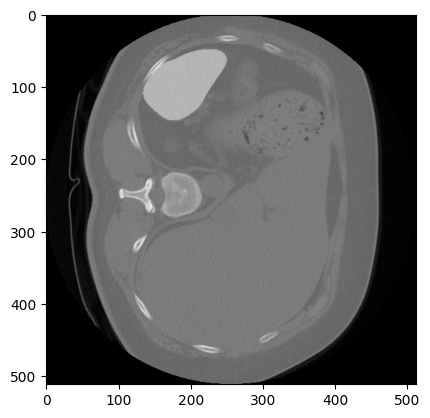

In [ ]:
# Visualizing Medical Image Slices with Matplotlib
#
# This block uses the `matplotlib` library to visualize a slice from a medical image volume and its corresponding label.
# - matplotlib.pyplot (imported as plt): A popular Python library for creating static, animated, and interactive visualizations.
#   - plt.imshow(): Displays an image on the axes. Key parameters:
#       - X: The image data (2D array).
#       - cmap: The colormap used to map scalar data to colors (e.g., "gray" for grayscale images).
#
# In this code:
# - `training_volume[:,:,5]` extracts the 6th slice (Python is zero-indexed) from the 3D CT scan volume.
# - `training_label[:,:,5]` extracts the corresponding segmentation label slice.
# - Multiplying the label by 500 visually highlights the segmented region when added to the image.
# - The sum overlays the segmentation mask on the original image for easy inspection.
# - The grayscale colormap ("gray") is used for visualization.

#
plt.imshow(training_volume[:,:,5] + training_label[:,:,5]*500, cmap="gray")

In [ ]:
# Checking Unique Classes in the Label Volume with NumPy
#
# This block uses the NumPy library to analyze the segmentation label data.
# - NumPy (imported as np): A fundamental package for numerical computations in Python, especially for array operations.
# - np.unique(array): Finds the sorted unique elements of an array. 
#   - Key parameter: `array` is the input array from which to find unique values.
#   - Returns: A sorted NumPy array of unique values present in the input.
#
# In this code:
# - We use np.unique(training_label) to determine how many distinct classes are present in the label volume.
#   This helps confirm whether the label is one-hot encoded or contains integer class labels.

# We assume our label has one-hot encoding. Let's confirm how many distinct classes do we have in our label volume
np.unique(training_label)

array([0., 1.])

Let's set up the training device. Do we have a GPU? 

In [ ]:
# Setting Up the PyTorch Device for Computation (CPU or GPU)
#
# This block determines whether a CUDA-capable GPU is available for PyTorch computations and sets the device accordingly.
# - torch.cuda.is_available(): Returns True if CUDA (NVIDIA GPU support) is available, otherwise False.
# - torch.device(type): Specifies the device type for tensor computations. Common values are "cuda" (GPU) and "cpu".
#   - If CUDA is available, tensors and models will be moved to the GPU for faster computation.
#   - If not, computations will default to the CPU.
# - The variable `device` is then used throughout the notebook to ensure tensors and models are consistently placed on the correct device.
#
# Example usage:
#   tensor.to(device)  # Moves a tensor to the selected device
#   model.to(device)   # Moves a model to the selected device

#

if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cpu')

Instantiate the U-Net class and get it ready for training. If you want to experiment with training hyperparameters, you can re-execute this cell to reset the model weights.


In [ ]:
# Instantiating and Preparing the U-Net Model for Training with PyTorch
#
# This block demonstrates how to instantiate a U-Net model and prepare it for training using the PyTorch library.
#
# - UNet: This is a custom neural network class (defined earlier) for image segmentation, based on the U-Net architecture.
#   - Key parameters:
#       - in_channels: Number of input channels (e.g., 1 for grayscale images).
#       - out_channels: Number of output channels/classes (e.g., 2 for background and spleen).
# - unet.to(device): Moves the model's parameters to the specified device (CPU or GPU) for computation.
# - torch.nn.CrossEntropyLoss: A loss function suitable for multi-class classification tasks, including per-pixel classification in segmentation.
# - optim.Adam: The Adam optimizer for updating model parameters during training.
#   - Key parameters:
#       - params: Model parameters to optimize.
#       - lr: Learning rate (controls the step size during optimization).
# - optimizer.zero_grad(): Resets gradients before each optimization step to prevent accumulation from previous steps.
#
# This setup ensures the model, loss function, and optimizer are ready for the training loop.

# Here we will use one input channel (one image at a time) and two output channels (background and label)
unet = UNet(1, 2) 

# Move all trainable parameters to the device
unet.to(device)

# We will use Cross Entropy loss function for this one - we are performing per-voxel classification task, 
# so it should do ok.
# Later in the lesson we will discuss what are some of the other options for measuring medical image 
# segmentation performance.

loss = torch.nn.CrossEntropyLoss()

# You can play with learning rate later to see what yields best results
optimizer = optim.Adam(unet.parameters(), lr=0.001)
optimizer.zero_grad()

In [ ]:
# Counting Trainable Parameters in a PyTorch Model
#
# This block demonstrates how to count the number of trainable parameters in a PyTorch neural network model.
#
# - PyTorch (torch): A popular deep learning library for building and training neural networks.
# - unet.parameters(): Returns an iterator over all parameters (weights and biases) of the model.
# - p.requires_grad: A boolean attribute indicating whether the parameter will be updated during training (i.e., is trainable).
# - p.numel(): Returns the total number of elements in the parameter tensor.
# - sum(...): Sums the number of elements for all trainable parameters, giving the total count of trainable parameters in the model.
#
# This is useful for understanding model complexity and comparing different architectures (e.g., 2D vs 3D convolutions).

#
# By the way, how many trainable parameters does our model have? If you will be playing 
# with 3D convolutions - compare the difference between 2D and 3D versions.

sum(p.numel() for p in unet.parameters() if p.requires_grad)

7762498

From here on let's create the training loop

## The training loop

In [ ]:
# Training Loop for U-Net Segmentation with PyTorch
#
# This block demonstrates how to train a U-Net model for medical image segmentation using the PyTorch library.
#
# Libraries and Functions:
# - PyTorch (torch): A deep learning framework for tensor computation and neural network training.
#   - unet.train(): Sets the model to training mode, enabling features like dropout and batch normalization updates.
#   - torch.from_numpy(): Converts a NumPy array to a PyTorch tensor.
#   - .unsqueeze(dim): Adds a dimension to the tensor (used to create batch and channel dimensions).
#   - .to(device): Moves the tensor to the specified device (CPU or GPU).
#   - .float() / .astype(np.float32): Ensures the data is in floating point format for neural network input.
#   - optimizer.zero_grad(): Clears old gradients from the last step before the backward pass.
#   - unet(slc_tensor): Performs a forward pass through the model to get predictions.
#   - loss(pred, lbl_tensor): Computes the loss between predictions and ground truth labels using CrossEntropyLoss.
#   - l.backward(): Computes gradients via backpropagation.
#   - optimizer.step(): Updates model parameters based on computed gradients.
#
# Key Parameters:
# - epoch: Number of training epochs (outer loop).
# - slice_ix: Index of the slice in the 3D volume (inner loop).
# - slc: 2D image slice extracted and normalized from the 3D volume.
# - lbl: Corresponding ground truth label for the slice.
# - CrossEntropyLoss: Expects integer class labels (not one-hot encoded) and raw logits as input.
#
# The loop iterates over a subset of slices (first 15) for each epoch, 
# normalizes the data, prepares tensors, computes loss, and updates the model.

#

%%time
# This is a basic training loop. Complete the code to run the model on first 15 slices 
# of the volume (that is where the spleen segmentation is - if you include more, you run the chances of background class
# overwhelming your tiny network with cross-entropy loss that we are using)

# Set up the model for training
unet.train()

for epoch in range(0,10):
    for slice_ix in range(0,15):
        # Let's extract the slice from the volume and convert it to tensor that the model will understand. 
        # Note that we normalize the volume to 0..1 range and ensure float32 type
        slc = training_volume[:,:,slice_ix].astype(np.float32)
        slc = slc / np.max(slc)
        
        # Our model accepts a tensor of size (batch_size, channels, w, h). We have batch of 1 and one channel, 
        # So create the missing dimensions. Also move data to our device and ensure float type
        slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(device).float()
        
        # Extract the slice from label volume into tensor that the network will accept.
        # Cross entropy loss expects integer class labels (int64)
        lbl = training_label[:,:,slice_ix].astype(np.int64)
        lbl_tensor = torch.from_numpy(lbl).unsqueeze(0).to(device)
        
        # Zero-out gradients from the previous pass so that we can start computation from scratch for this backprop run
        optimizer.zero_grad()
        
        # Do the forward pass
        pred = unet(slc_tensor)
        
        # Here we compute our loss function and do the backpropagation pass
        l = loss(pred, lbl_tensor)
        l.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch}, training loss: {l}")
    

Epoch: 0, training loss: 0.327579140663147
Epoch: 1, training loss: 0.32466503977775574
Epoch: 2, training loss: 0.32335588335990906
Epoch: 3, training loss: 0.32212546467781067
Epoch: 4, training loss: 0.3211616575717926
Epoch: 5, training loss: 0.3202093839645386
Epoch: 6, training loss: 0.3197006285190582
Epoch: 7, training loss: 0.31939640641212463
Epoch: 8, training loss: 0.3184504210948944
Epoch: 9, training loss: 0.3182220757007599
CPU times: user 3min 6s, sys: 3min 2s, total: 6min 8s
Wall time: 1min 57s


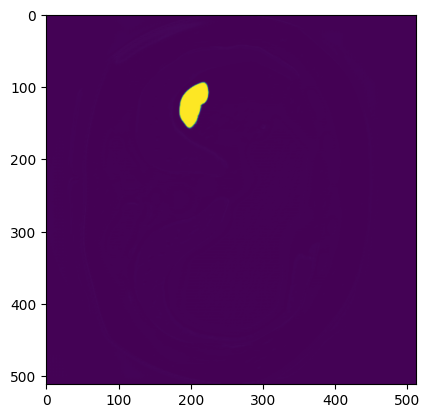

In [ ]:
# Visualizing U-Net Segmentation Output with Matplotlib
#
# This block demonstrates how to visualize the output of a U-Net segmentation model using the matplotlib library.
#
# - matplotlib.pyplot (imported as plt): A widely used Python library for creating static, animated, and interactive visualizations.
#   - plt.imshow(): Displays an image on the axes.
#       - Key parameters:
#           - X: The image data (2D array or tensor).
#           - cmap: The colormap used to map scalar data to colors (optional, e.g., "gray").
#   - plt.show(): Renders the current figure.
#

# In this code:
# - pred: The output tensor from the U-Net model, typically with shape (batch_size, num_classes, height, width).
# - pred.cpu().detach(): Moves the tensor to CPU and detaches it from the computation graph, making it suitable for visualization.
# - [0,1]: Selects the first batch and the second channel (e.g., the spleen class probability map).
# - plt.imshow(pred.cpu().detach()[0,1]): Visualizes the probability map for the target class using the default colormap.

# Here's a neat trick: let's visualize our last network prediction with default colormap in matplotlib:
# (note the .cpu().detach() calls - we need to move our data to CPU before manipulating it and we need to 
# stop collecting the computation graph)

plt.imshow(pred.cpu().detach()[0,1])

Isn't this a nice visualization of what draws our CNN's attention after these few runs? 

Try re-executing the training cell a few times to see how this attention improves as network learns more

## Save results

Lastly, let's run inference on all slices of our volume, turn them into the binary map and save as NIFTI! We will use it in the next exercise.

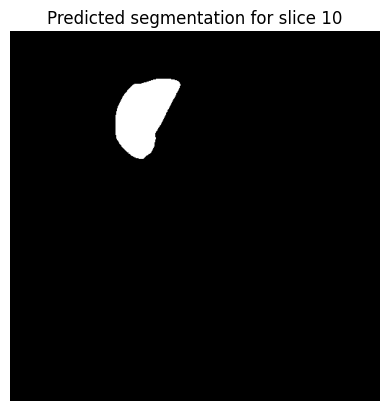

In [ ]:
# Inference and Visualization of U-Net Segmentation Output for a Single Slice
#
# This block demonstrates how to run inference on a single slice of a 3D medical image using a trained U-Net model,
# convert the output to a NumPy array, and visualize the segmentation result.
#
# Libraries and Functions:
# - torch: PyTorch is used for tensor operations and running the neural network model.
#   - torch.from_numpy(): Converts a NumPy array to a PyTorch tensor.
#   - .unsqueeze(dim): Adds a dimension to the tensor (used to create batch and channel dimensions).
#   - .to(device): Moves the tensor to the specified device (CPU or GPU).
#   - .float(): Ensures the tensor is in floating point format.
#   - torch.no_grad(): Context manager that disables gradient calculation, useful for inference.
#   - torch.argmax(input, dim): Returns the indices of the maximum values along a specified dimension (used to get predicted class).
# - matplotlib.pyplot as plt: Used for visualizing the segmentation mask.
#   - plt.imshow(): Displays an image (2D array) with optional colormap.
#   - plt.title(): Sets the title of the plot.
#   - plt.axis(): Sets axis properties (e.g., "off" to hide axes).
#   - plt.show(): Renders the plot.
#
# Key Steps:
# 1. Set the model to evaluation mode with unet.eval().
# 2. Select a slice index from the 3D volume.
# 3. Normalize the slice and convert it to a PyTorch tensor with appropriate dimensions.
# 4. Run inference using the trained U-Net model.
# 5. Convert the output to a 2D NumPy array by taking the class with the highest probability.
# 6. Visualize the predicted segmentation mask using matplotlib.

# TASK: pick a slice from the loaded training_volume Numpy array, convert it into PyTorch tensor,
# and run an inference on it, convert result into 2D NumPy array and visualize it. 
# Don't forget to normalize your data before running inference! Also keep in mind
# that our CNN return 2 channels - one for each class - target (spleen) and background 

# <YOUR CODE HERE>

# Let's run inference on just one slice first

# Switch model to the eval mode so that no gradient collection happens
unet.eval()

# Pick a slice index (for example, slice 10)
slice_ix = 10

# Extract and normalize the slice
slc = training_volume[:, :, slice_ix].astype(np.float32)
slc = slc / np.max(slc)

# Convert to PyTorch tensor and move to device
slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(device).float()

# Run inference (no gradients needed)
with torch.no_grad():
    pred = unet(slc_tensor)

# Convert prediction to numpy (take the class with highest probability)
pred_np = torch.argmax(pred, dim=1).cpu().numpy()[0]

# Visualize the result
plt.imshow(pred_np, cmap="gray")
plt.title(f"Predicted segmentation for slice {slice_ix}")
plt.axis("off")
plt.show()



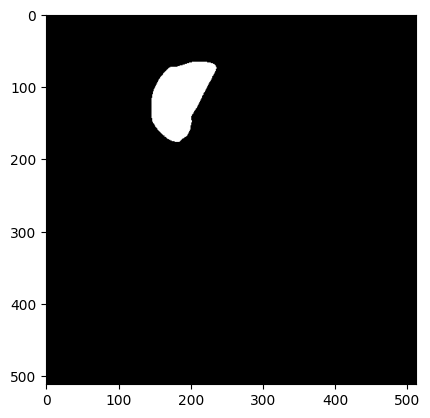

In [ ]:
# Visualizing Segmentation Masks with PyTorch and Matplotlib
#
# This block demonstrates how to convert a model's prediction tensor into a binary segmentation mask using PyTorch,
# and visualize it using matplotlib.
#
# Libraries and Functions:
# - torch: PyTorch is used for tensor operations and deep learning.
#   - torch.argmax(input, dim): Returns the indices of the maximum values along a specified dimension.
#     - input: The input tensor (e.g., model output with class probabilities or logits).
#     - dim: The dimension along which to compute the argmax (for segmentation, usually the channel/class dimension).
#   - .squeeze(dim): Removes dimensions of size 1 from the tensor shape.
#     - dim: The dimension to squeeze (e.g., batch dimension).
# - matplotlib.pyplot (plt): Used for plotting and visualizing images.
#   - plt.imshow(X, cmap): Displays an image.
#     - X: The image data (2D array or tensor).
#     - cmap: The colormap (e.g., "gray" for grayscale images).
#

# Now let's convert this into binary mask using PyTorch's argmax function:

mask = torch.argmax(pred, dim=1).squeeze(0)
plt.imshow(mask, cmap="gray")

In [ ]:
# Creating a 3D Segmentation Mask Volume from U-Net Predictions with PyTorch and NumPy
#
# This block demonstrates how to use a trained U-Net model to generate segmentation predictions for each slice of a 3D medical image volume,
# aggregate the results into a 3D NumPy array, and prepare it for saving as a NIfTI file.
#
# Libraries and Functions:
# - PyTorch (torch): Used for model inference and tensor operations.
#   - torch.from_numpy(): Converts a NumPy array to a PyTorch tensor.
#   - .unsqueeze(dim): Adds a dimension to the tensor (for batch and channel).
#   - .to(device): Moves the tensor to the specified device (CPU or GPU).
#   - .float(): Ensures the tensor is in floating point format.
#   - torch.no_grad(): Context manager that disables gradient calculation during inference.
#   - torch.argmax(input, dim): Returns the indices of the maximum values along a specified dimension (used to get predicted class).
# - NumPy (np): Used for array operations and to store the final 3D mask.
#   - np.zeros(shape, dtype): Creates an array of zeros with the given shape and data type.
#
# Key Steps:
# 1. Set the U-Net model to evaluation mode to disable training-specific layers.
# 2. Prepare an empty 3D NumPy array (mask3d) to store the predicted masks for each slice.
# 3. Loop over all slices in the input volume:
#    - Normalize each slice and convert it to a PyTorch tensor with appropriate dimensions.
#    - Run inference using the trained U-Net model (with no gradients).
#    - Use torch.argmax to get the predicted class for each pixel.
#    - Store the resulting 2D mask in the corresponding slice of the 3D array.

# TASK: Now you have all you need to create a full NIFTI volume. Compute segmentation predictions 
# for each slice of your volume and turn them into NumPy array of the same shape as the original volume

# Switch model to evaluation mode
unet.eval()

# Prepare an empty array to store the predicted masks
mask3d = np.zeros(training_volume.shape, dtype=np.uint8)

# Loop over all slices in the volume
for slice_ix in range(training_volume.shape[2]):
    # Extract and normalize the slice
    slc = training_volume[:, :, slice_ix].astype(np.float32)
    slc = slc / np.max(slc)
    # Convert to PyTorch tensor and move to device
    slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(device).float()
    # Run inference (no gradients needed)
    with torch.no_grad():
        pred = unet(slc_tensor)
    # Convert prediction to numpy (take the class with highest probability)
    pred_np = torch.argmax(pred, dim=1).cpu().numpy()[0]
    # Store the mask in the corresponding slice
    mask3d[:, :, slice_ix] = pred_np


One thing to note here: 

Remember that [IPP/IOP](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html) and "affine" thing I mentioned during lesson on DICOM and NIFTI file formats? Let's check it, just in case if this volume is not aligned perfectly against the coordinate axes

In [ ]:
# Checking and Using the Affine Matrix from a NIfTI Image with NiBabel
#
# Library:
# - nibabel (imported as nib): A Python library for reading and writing medical imaging data, especially NIfTI files (.nii, .nii.gz).
#
# Key Functions:
# - nib.load(filename): Loads a NIfTI file from disk and returns a Nifti1Image object.
#     - filename: Path to the NIfTI file.
# - Nifti1Image.affine: Attribute of the Nifti1Image object that provides the affine transformation matrix.
#     - The affine matrix encodes the mapping from voxel coordinates to world (scanner) coordinates.
#
# Key Steps:
# 1. Load the original NIfTI image using nib.load.
# 2. Access and display the affine matrix to check the spatial orientation and position of the image.


org_volume = nib.load("data/spleen1_img.nii.gz")
org_volume.affine

array([[   0.68359399,    0.        ,    0.        , -349.31652832],
       [   0.        ,    0.68359399,    0.        , -349.31652832],
       [   0.        ,    0.        ,    5.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

And it's not!

It is quite important to not forget your coordinate system transforms it when you are saving your mask if you want it to line up with your volume properly. Sometimes your affine is just an identity matrix, but sometimes (like on this volume) it's quite a bit more interesting. If you want to geek out on NIFTI affines, take a look at this: https://nipy.org/nibabel/coordinate_systems.html

In [ ]:
# Saving a 3D Segmentation Mask as a NIfTI Image with NiBabel
#
# Library:
# - nibabel (imported as nib): A Python library for reading and writing medical imaging data, especially NIfTI files (.nii, .nii.gz).
#
# Key Functions:
# - nib.Nifti1Image(data, affine): Creates a NIfTI image object from a NumPy array and an affine transformation matrix.
#     - data: The 3D NumPy array containing the segmentation mask (e.g., mask3d).
#     - affine: The affine matrix from the original image (e.g., org_volume.affine) to ensure correct spatial orientation.
# - nib.save(img, filename): Saves the NIfTI image object to disk.
#     - img: The Nifti1Image object to save.
#     - filename: The path where the NIfTI file will be saved.
#
# Key Steps:
# 1. Create a NIfTI image from the predicted 3D mask and the original image's affine matrix.
# 2. Save the resulting NIfTI image to disk for further analysis or visualization.

# Finally, save our NIFTI image, copying affine from the original image

img_out = nib.Nifti1Image(mask3d, org_volume.affine)
nib.save(img_out, "data/out.nii.gz")

## Concluding remarks
Congrats, you have finished the exercise and trained your very own U-net for biomedical image segmentation!

If you want to dive deeper, here are a few suggestions:

* Try playing with the depth of UNet stacks and see how it affects your quality.
* In the last exercise you have been writing your own convolutions. Try changing the model architecture to one that that works with 2.5D or 3D convolutions.
* Later in this lesson we will talk about Dice and Jaccard similarity measures. Once you get familiar with that content, try changing the loss function and see how it affects the performance. Look up "soft dice" loss function